In [108]:
# MobileNetV3로 만들기
'''
https://www.kaggle.com/code/guanlintao/mobilenetv3-jellyfish-image-predict/notebook
여기에 있는 코드처럼 수정해서 성능을 올려야할 것 같은데, 일단 GPT로 한번 학습 성공하는데 의의를 두고 코드를 수정함
'''
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small  # Small 모델을 사용, 너무 성능이 저조하면 Large 모델로 변경
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout   # 배치 정규화, 드롭아웃
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  # 체크포인트(콜백)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop  # 옵티마이저

In [109]:
# Dataset path and categories
dataset_path = "../_preprocessed_datasets_origin"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

# Image size and hyperparameters
img_height, img_width = 224, 224 
batch_size = 16
epochs = 40

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [80]:
# Prepare data
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(label)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

In [81]:
# Split data into train, validation, and test sets
train_files, test_files, train_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Create DataFrame
def create_dataframe(files, labels, categories):
    label_to_class = {idx: name for idx, name in enumerate(categories)}
    labels = [label_to_class[label] for label in labels]
    return pd.DataFrame({'filename': files, 'class': labels})

train_df = create_dataframe(train_files, train_labels, categories)
val_df = create_dataframe(val_files, val_labels, categories)
test_df = create_dataframe(test_files, test_labels, categories)

In [100]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)



Found 768 validated image filenames belonging to 6 classes.
Found 192 validated image filenames belonging to 6 classes.
Found 240 validated image filenames belonging to 6 classes.


In [121]:
# Load MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# Build the model 여기를 추가해야 학습이 진행됨
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # 배치 정규화 추가
x = Dense(256, activation='relu')(x)  # 배치 정규화 층 옮기기 fully-connected layer 내부 -> 이전
x = Dropout(0.4)(x)  # 드롭아웃
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # 드롭아웃
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)  # 드롭아웃
x = Dense(32, activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


# Freeze the first few layers and unfreeze the rest 수정한 코드
for layer in base_model.layers[:-10]:  # 마지막 10개의 레이어는 학습 가능하게 설정
    layer.trainable = False


In [122]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_memory_info('GPU:0')
        print(f"GPU 메모리 상태: {details}")
else:
    print("GPU가 감지되지 않았습니다.")

GPU 메모리 상태: {'current': 61213184, 'peak': 3038876928}


In [123]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[model_checkpoint, reduce_lr],
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)


Epoch 1/40
24/24 [==============================] - 5s 103ms/step - loss: 1.8391 - accuracy: 0.2435 - val_loss: 1.7730 - val_accuracy: 0.2135
Epoch 2/40
24/24 [==============================] - 2s 85ms/step - loss: 1.7681 - accuracy: 0.2695 - val_loss: 1.7651 - val_accuracy: 0.2135
Epoch 3/40
24/24 [==============================] - 2s 72ms/step - loss: 1.6718 - accuracy: 0.2982 - val_loss: 1.7728 - val_accuracy: 0.3021
Epoch 4/40
24/24 [==============================] - 2s 67ms/step - loss: 1.6601 - accuracy: 0.3177 - val_loss: 1.7751 - val_accuracy: 0.2031
Epoch 5/40
24/24 [==============================] - 2s 70ms/step - loss: 1.5960 - accuracy: 0.3372 - val_loss: 1.7680 - val_accuracy: 0.2083
Epoch 6/40
24/24 [==============================] - 2s 73ms/step - loss: 1.5286 - accuracy: 0.3776 - val_loss: 1.7623 - val_accuracy: 0.2083
Epoch 7/40
24/24 [==============================] - 2s 68ms/step - loss: 1.5013 - accuracy: 0.3659 - val_loss: 1.7531 - val_accuracy: 0.2083
Epoch 8/40
2

In [124]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

7/7 [==============================] - 0s 53ms/step - loss: 1.3589 - accuracy: 0.4107
Test Loss: 1.3589, Test Accuracy: 0.4107


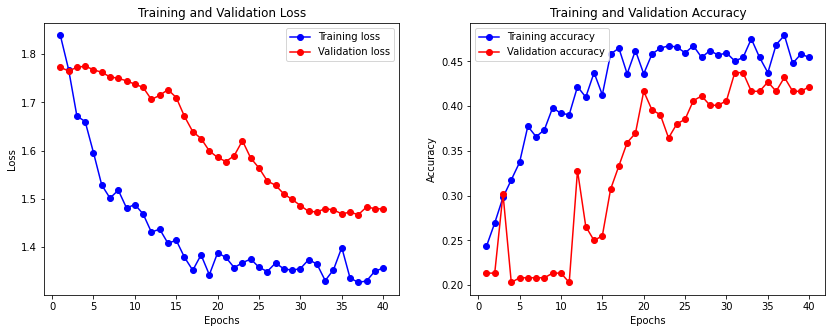

In [125]:
# Plot training history
def plot_training_history(history):
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot training and validation history
plot_training_history(history)

In [ ]:
#  오차값과 정확도가 들쑥날쑥한다 => 학습률을 낮춰보자.
# 낮췄더니 loss값이 너무 느리게 내려감 -> 모델 크기를 키워보자
# 그냥  Small Large 사전학습 모델 차이인가..;; -> 씨이이잇팔 이것도 아닌듯
# 모델을 키워놨더니 그냥